# Transfer Learning for Computer Vision Tutorial

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at cs231n notes

Quoting these notes,

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

These two major transfer learning scenarios look as follows:

    Finetuning the ConvNet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

    ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

#running on a mac 
#import torch.backends.cudnn as cudnn 

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS backend.")
elif torch.cuda.is_available():
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True
    device = torch.device("cuda")
    print("Using NVIDIA CUDA backend with cuDNN.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

#cudnn.benchmark = True
plt.ion()   # interactive mode

Using Apple MPS backend.


## Load Data 

We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

Note

Download the data from here and extract it to the current directory.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


## Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.



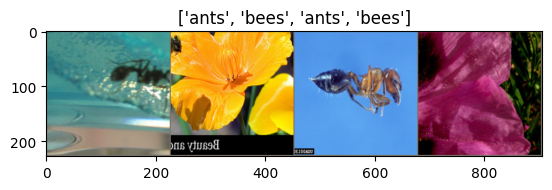

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

    Scheduling the learning rate
    
    Saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.



In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                #epoch_acc = running_corrects.double() / dataset_sizes[phase] mps doesn't supprot float64 so use float32
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet
Load a pretrained model and reset final fully connected layer.



In [10]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.



In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5840 Acc: 0.6762
val Loss: 0.2430 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.4803 Acc: 0.7787
val Loss: 0.4415 Acc: 0.8105

Epoch 2/24
----------
train Loss: 0.4425 Acc: 0.8238
val Loss: 0.2848 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5450 Acc: 0.7787
val Loss: 0.3204 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.5690 Acc: 0.7664
val Loss: 0.4363 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5308 Acc: 0.7910
val Loss: 0.4856 Acc: 0.8301

Epoch 6/24
----------
train Loss: 0.5979 Acc: 0.7705
val Loss: 0.8529 Acc: 0.7647

Epoch 7/24
----------
train Loss: 0.3285 Acc: 0.8525
val Loss: 0.2518 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3374 Acc: 0.8811
val Loss: 0.2481 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3552 Acc: 0.8648
val Loss: 0.2125 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3429 Acc: 0.8566
val Loss: 0.2123 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2852 Acc: 0.8893
val Loss: 0.2044 Acc: 0.9477

Ep

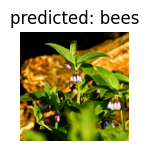

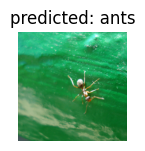

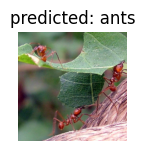

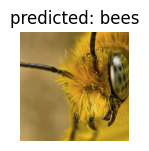

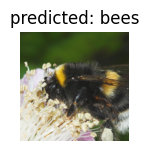

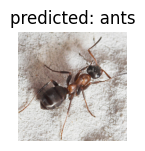

In [12]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [15]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5940 Acc: 0.6639
val Loss: 0.2455 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4990 Acc: 0.7828
val Loss: 0.3006 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.4298 Acc: 0.7951
val Loss: 0.2055 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.5779 Acc: 0.7377
val Loss: 0.1989 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.4053 Acc: 0.8279
val Loss: 0.2318 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3804 Acc: 0.8402
val Loss: 0.1951 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4092 Acc: 0.8484
val Loss: 0.2440 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.2580 Acc: 0.8975
val Loss: 0.1904 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3309 Acc: 0.8689
val Loss: 0.1998 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3638 Acc: 0.8484
val Loss: 0.1838 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3738 Acc: 0.8197
val Loss: 0.1724 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2649 Acc: 0.8770
val Loss: 0.1961 Acc: 0.9412

Ep

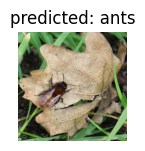

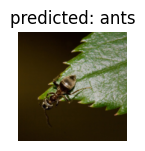

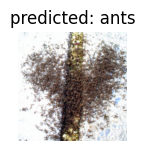

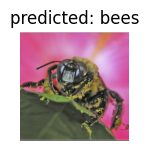

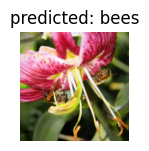

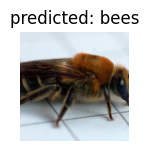

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images
Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.

In [18]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

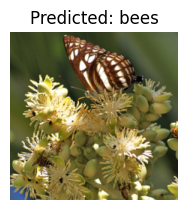

In [19]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning
If you would like to learn more about the applications of transfer learning, checkout our Quantized Transfer Learning for Computer Vision Tutorial.

https://docs.pytorch.org/tutorials/index.html